In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict

import importlib
import utils
importlib.reload(utils)
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True

In [2]:
reset_seeds()

train_size = 200
val_size = 10_000
noise_coeff = 0.2
dims = 50
true_weights = torch.randn(dims, 1)*3/np.sqrt(dims)
true_intercept = torch.randn(1)

with torch.no_grad():
    train_sample_x = torch.randn(train_size, dims)
    train_sample_y = train_sample_x @ true_weights + true_intercept + torch.randn(train_size, 1)*noise_coeff

    val_sample_x = torch.randn(val_size, dims)
    val_sample_y = val_sample_x @ true_weights + true_intercept + torch.randn(val_size, 1)*noise_coeff

    train_dataset = torch.utils.data.TensorDataset(train_sample_x, train_sample_y)
    val_dataset = torch.utils.data.TensorDataset(val_sample_x, val_sample_y)

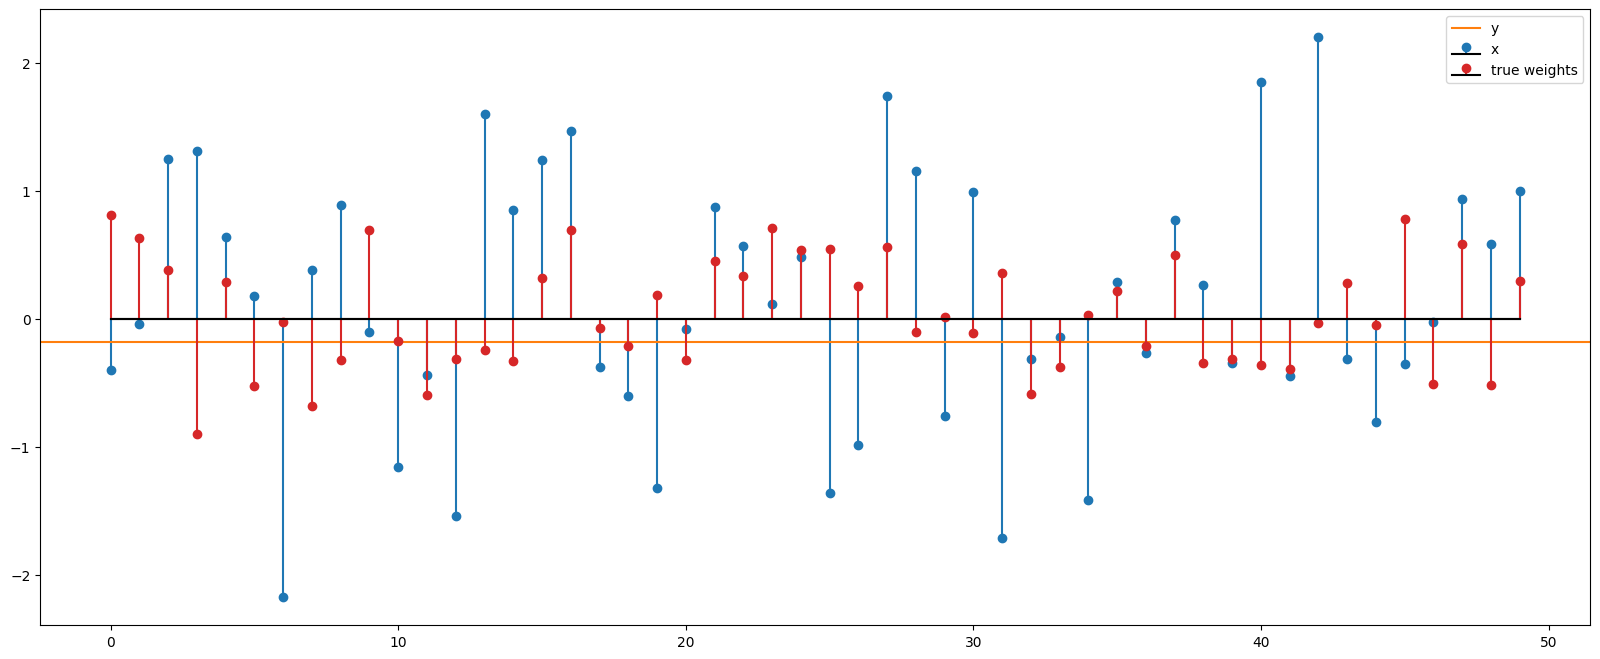

In [3]:
ind = np.random.randint(0, train_size)
fig, ax = plt.subplots(figsize=(20, 8))
ax.stem(train_sample_x[ind].numpy(), label='x', markerfmt='C0o', linefmt='C0', basefmt='k-')
ax.axhline(train_sample_y[ind].numpy(), label='y', c="C1")
ax.stem(true_weights.numpy(), label='true weights', markerfmt='C3o', linefmt='C3-', basefmt='k-')
ax.legend();

## Is the task possible?

/Users/tomkite/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

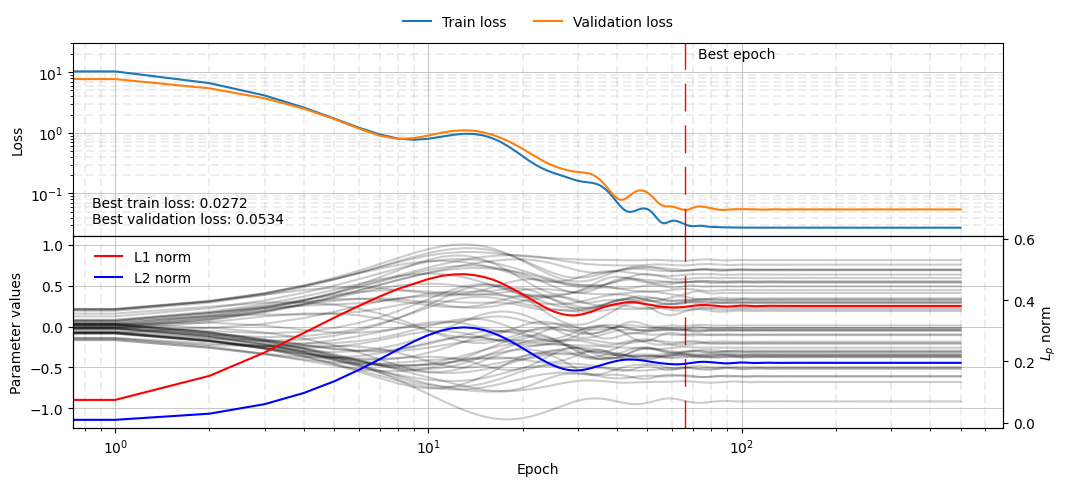

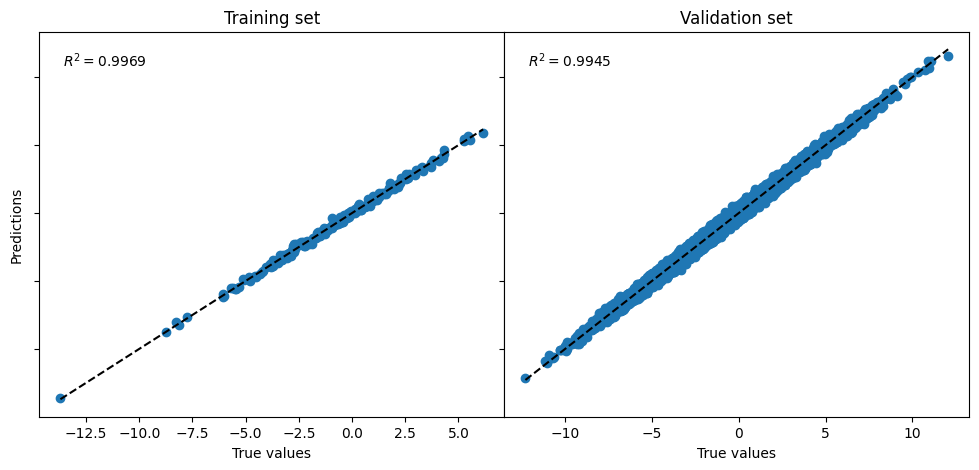

In [4]:
model = SimpleLinear(in_features=dims, out_features=1).to(device)
linear_regression_histories = training_loop(model, train_dataset, val_dataset, num_epochs=500, lr=0.1, device=device)
plot_training_visualisation(linear_regression_histories, alpha=0.2, savename="linear_benchmark.png")
plot_predictions_vs_truth(linear_regression_histories["model"], train_dataset, val_dataset, device, savename="linear_benchmark_predictions.png")

  0%|          | 0/1000 [00:00<?, ?it/s]

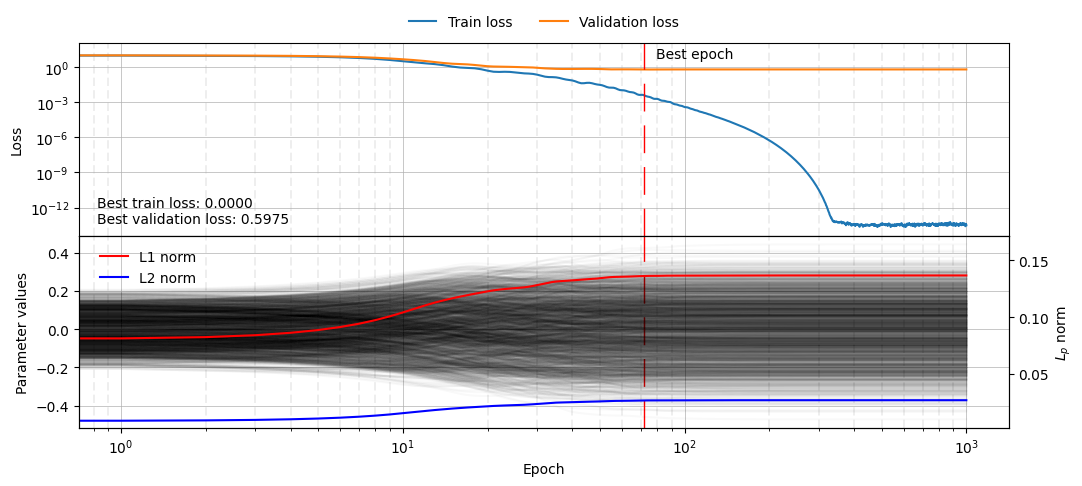

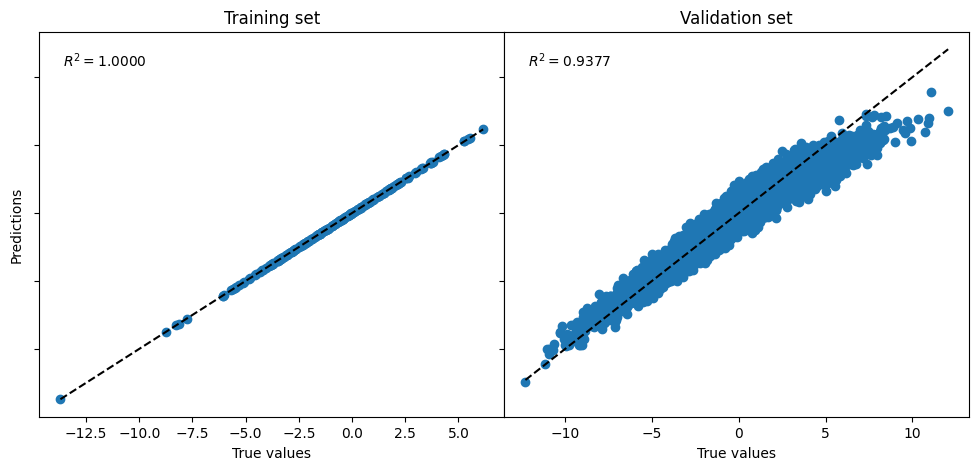

In [5]:
model = MLP([dims, 25, 25, 1]).to(device)
mlp_histories = training_loop(model, train_dataset, val_dataset, num_epochs=1_000, lr=0.01, device=device)
plot_training_visualisation(mlp_histories, savename="mlp_benchmark.png")
plot_predictions_vs_truth(mlp_histories["model"], train_dataset, val_dataset, device, savename="mlp_benchmark_predictions.png")

## Now with Weight decay

  0%|          | 0/1000 [00:00<?, ?it/s]

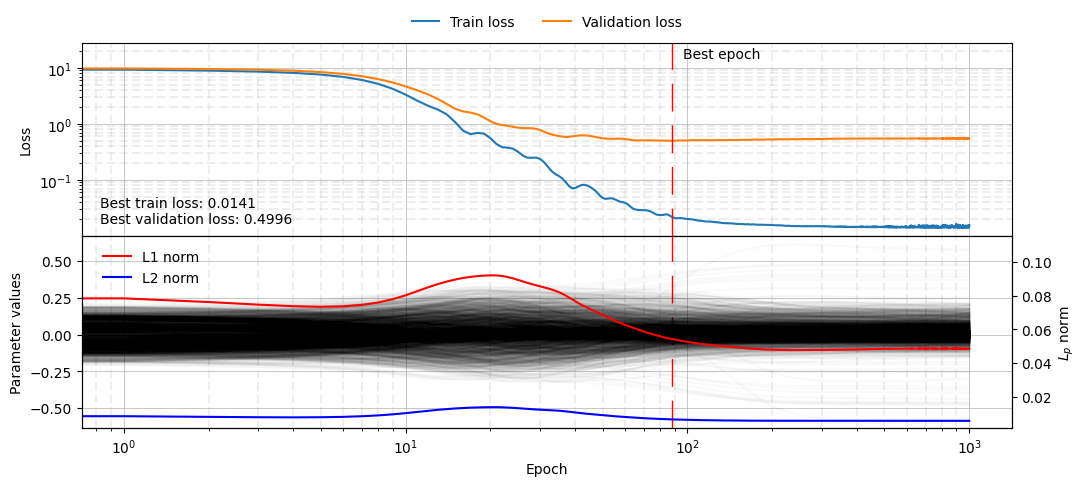

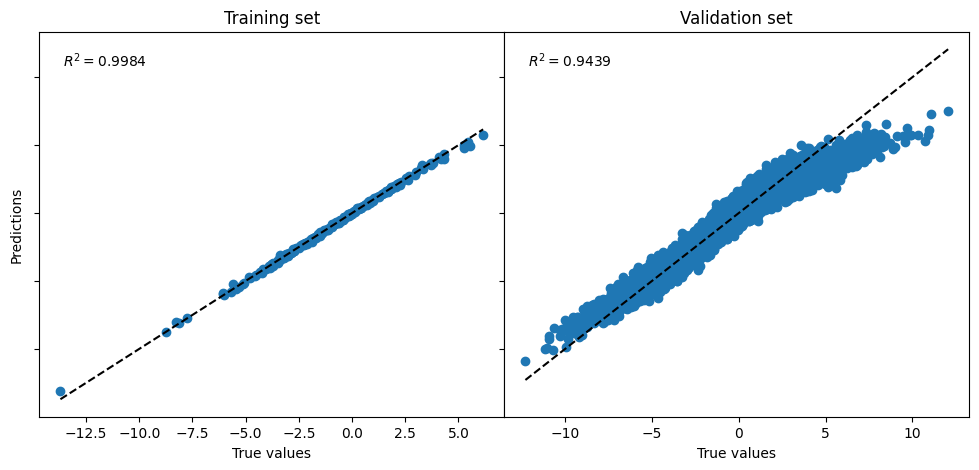

In [6]:
model = MLP([dims, 25, 25, 1])
mlp_weight_decay_histories = training_loop(model, train_dataset, val_dataset, num_epochs=1_000, lr=0.01, weight_decay=0.085, device=device)
plot_training_visualisation(mlp_weight_decay_histories, savename="mlp_weight_decay.png")
plot_predictions_vs_truth(mlp_weight_decay_histories["model"], train_dataset, val_dataset, device)

## Now with manual L2 regularization (weight decay)

  0%|          | 0/1000 [00:00<?, ?it/s]

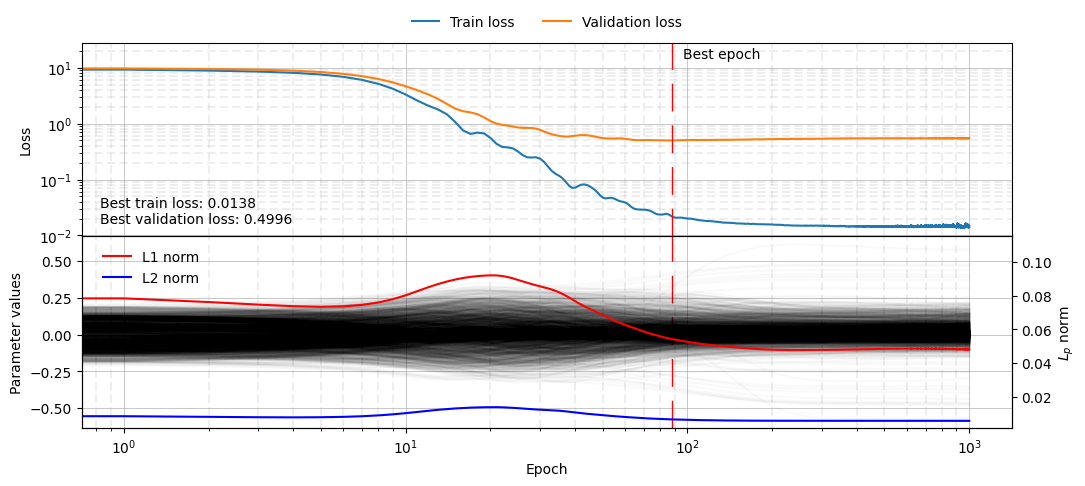

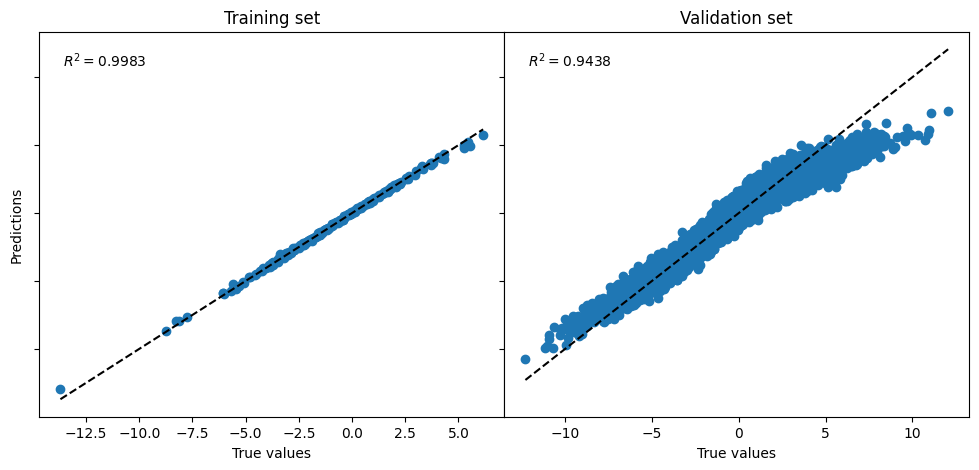

In [7]:
model = MLP([dims, 25, 25, 1])
mlp_l2_reg_histories = training_loop(model, train_dataset, val_dataset, num_epochs=1_000, lr=0.01, l2_reg=0.085, device=device)
plot_training_visualisation(mlp_l2_reg_histories, savename="mlp_l2_reg.png")
plot_predictions_vs_truth(mlp_l2_reg_histories["model"], train_dataset, val_dataset, device)

## Now with L1 regularization

  0%|          | 0/2000 [00:00<?, ?it/s]

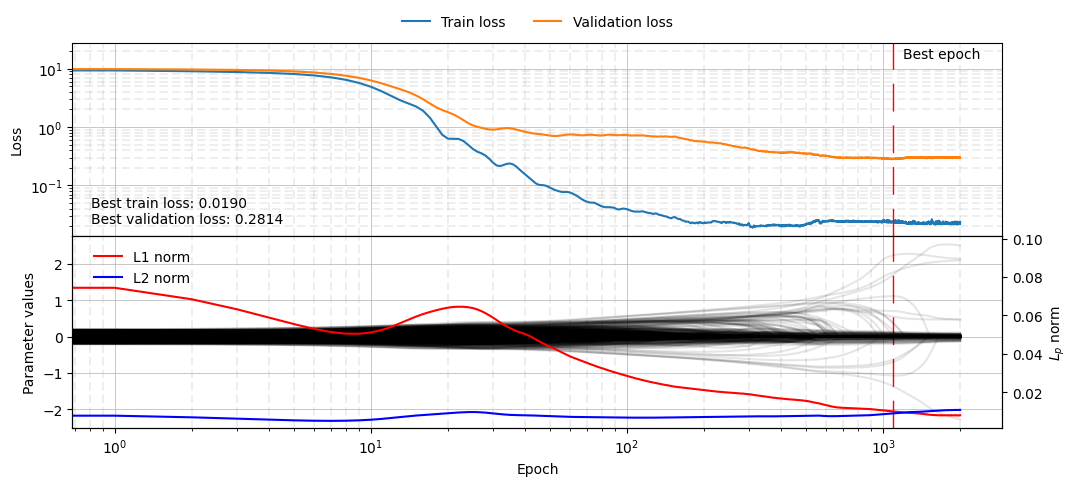

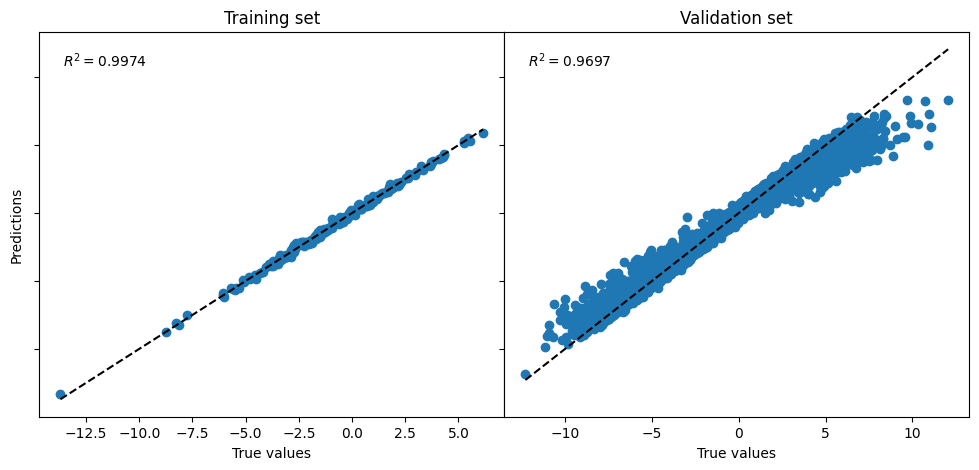

In [8]:
model = MLP([dims, 25, 25, 1])
mlp_l1_reg_histories = training_loop(model, train_dataset, val_dataset, num_epochs=2_000, lr=0.01, l1_reg=0.021, device=device)
plot_training_visualisation(mlp_l1_reg_histories, alpha=0.1, savename="mlp_l1_reg.png")
plot_predictions_vs_truth(mlp_l1_reg_histories["model"], train_dataset, val_dataset, device)

## Regularization by batch size

  0%|          | 0/1000 [00:00<?, ?it/s]

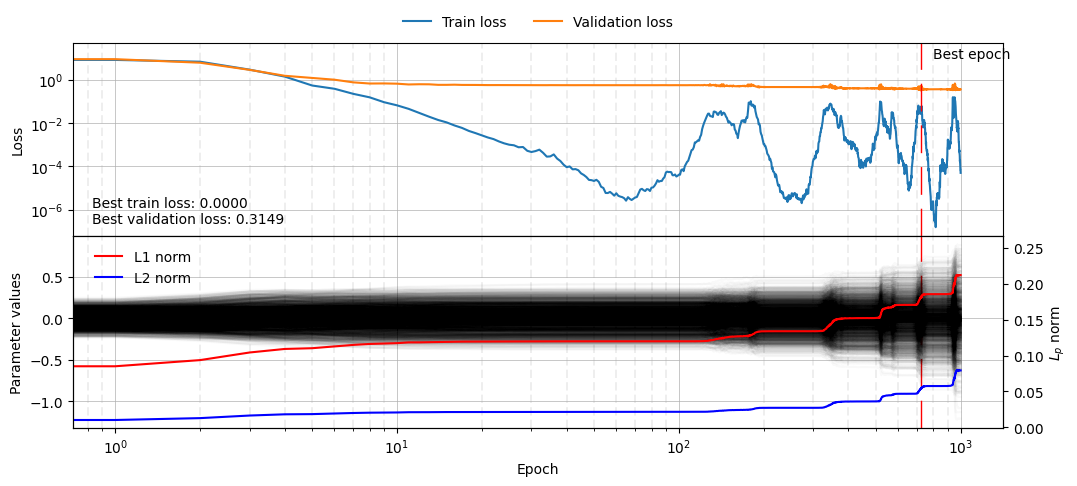

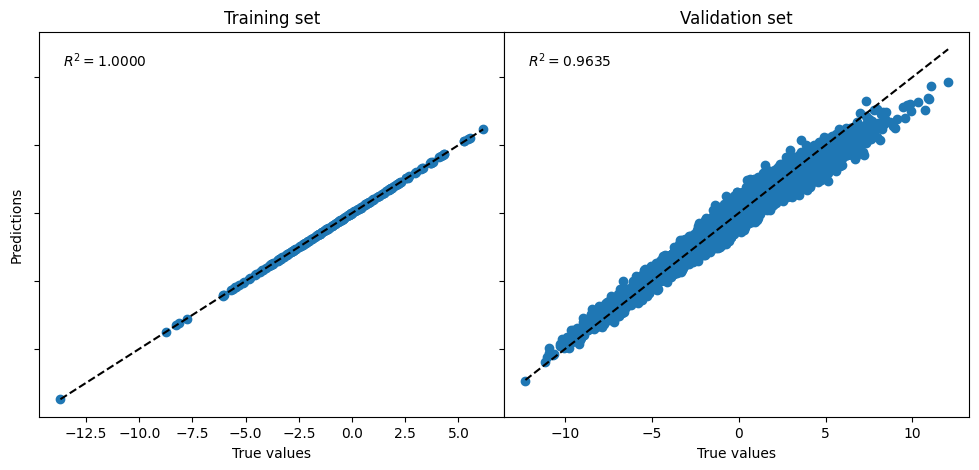

In [9]:
model = MLP([dims, 25, 25, 1])
mlp_minibatch_histories = training_loop(model, train_dataset, val_dataset, num_epochs=1_000, lr=0.01, batch_size=32, device=device)
plot_training_visualisation(mlp_minibatch_histories, savename="mlp_minibatch.png")
plot_predictions_vs_truth(mlp_minibatch_histories["model"], train_dataset, val_dataset, device)

## Dropout

  0%|          | 0/2000 [00:00<?, ?it/s]

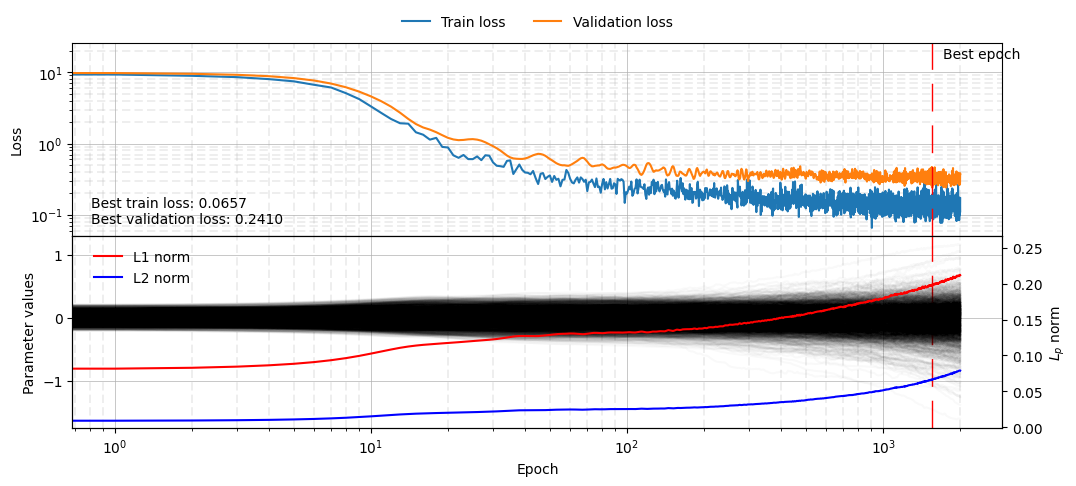

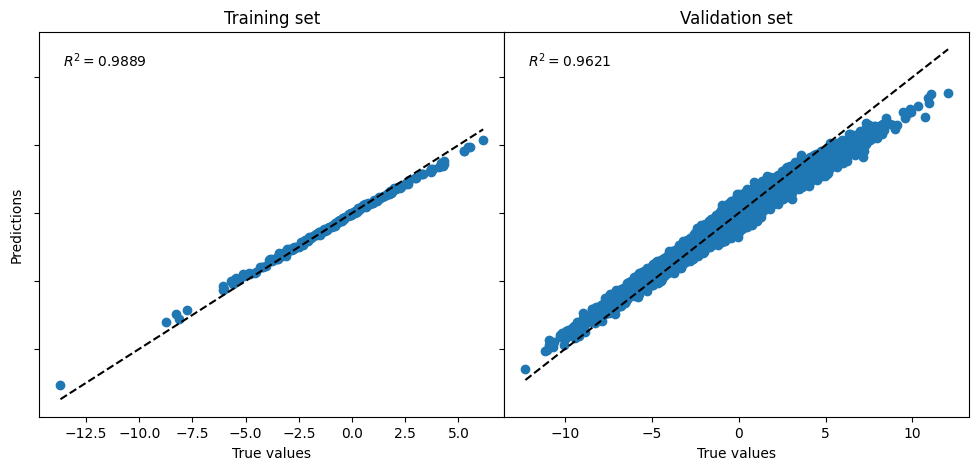

In [10]:
model = MLP([dims, 25, 25, 1], dropout=0.1)
mlp_dropout_histories = training_loop(model, train_dataset, val_dataset, num_epochs=2_000, lr=0.01, device=device)
plot_training_visualisation(mlp_dropout_histories, savename="mlp_dropout.png")
plot_predictions_vs_truth(mlp_dropout_histories["model"], train_dataset, val_dataset, device)

### Comparison

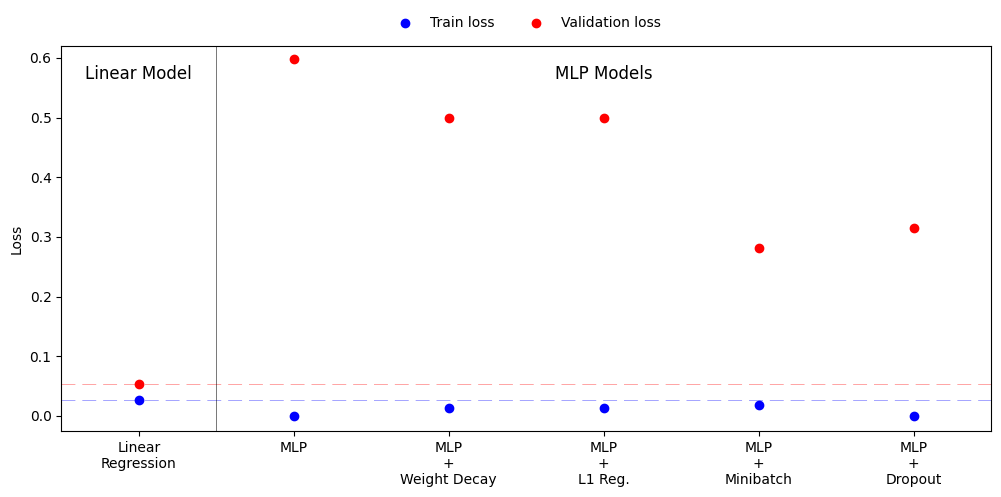

In [22]:
model_names = [
    "Linear\nRegression",
    "MLP",
    "MLP\n+\nWeight Decay",
    "MLP\n+\nL1 Reg.",
    "MLP\n+\nMinibatch",
    "MLP\n+\nDropout",
]
histories = [
    linear_regression_histories,
    mlp_histories,
    mlp_weight_decay_histories,
    mlp_l2_reg_histories,
    mlp_l1_reg_histories,
    mlp_minibatch_histories,
    mlp_dropout_histories,
]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for ind, (name, history) in enumerate(zip(model_names, histories)):
    best_train_loss = min(history['train_loss'])
    best_val_loss = min(history['val_loss'])
    ax.scatter(ind, best_train_loss, c='b', label='Train loss' if ind == 0 else None)
    ax.scatter(ind, best_val_loss, c='r', label='Validation loss' if ind == 0 else None)

    if ind == 0:
        ax.axhline(best_train_loss, c='b', dashes=[20,10], alpha=0.5, lw=0.5)
        ax.axhline(best_val_loss, c='r', dashes=[20,10], alpha=0.5, lw=0.5)

ax.axvline(0.5, c='k', ls='-', alpha=0.75, lw=0.5)
ax.text(0, 0.95, 'Linear Model', ha='center', va='top', fontsize=12, transform=ax.get_xaxis_transform(), c='k')
ax.text(3, 0.95, 'MLP Models', ha='center', va='top', fontsize=12, transform=ax.get_xaxis_transform(), c='k')

ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=0)
ax.set(ylabel='Loss', ylim=(-0.025, 0.62), xlim=(-0.5, len(model_names)-0.5))
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), ncol=2, frameon=False)
plt.savefig("figures/benchmark_results.png", dpi=300, bbox_inches='tight')
plt.show()